In [12]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'
# Subjects and tasks
taskList=['pres1', 'pres2','pres3']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))

def classifySS(classifier,analysis):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(SSvars, columns=['sub','task'])
    dfSS=pd.DataFrame()
    dfSS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfSS['sub']=tmp_df['sub']
    for index, row in dfSS.iterrows():
        score=model(classifier, analysis, train_sub=row['sub'], test_sub=row['sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfSS['acc']=acc_scores_per_task
    results.plotACC(dfSS, classifier, analysis)
    results.statsACC(dfSS, classifier, analysis)
    results.boxACC(dfSS, classifier, analysis)
    #save accuracy
    dfSS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc_pres.csv', index=False)
    
def model(classifier, analysis, train_sub, test_sub, train_task, test_task):
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.matFiles(dataDir+'mem/'+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    #if your subs are the same
    if train_sub==test_sub:
        test_taskFC=reshape.matFiles(dataDir+'mem/'+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        ACCscores=CV_folds(clf, analysis, taskFC, restFC, test_taskFC, restFC)
    else:
        test_taskFC=reshape.matFiles(dataDir+'mem/'+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        test_restFC=reshape.matFiles(dataDir+'rest/'+test_sub+'_parcel_corrmat.mat')
        ACCscores=CV_folds(clf, analysis, taskFC, restFC, test_taskFC, test_restFC)
    return ACCscores
def CV_folds(clf, analysis, taskFC, restFC, test_taskFC, test_restFC):
    loo = LeaveOneOut()
    taskSize=taskFC.shape[0]
    restSize=restFC.shape[0]
    t = np.ones(taskSize, dtype = int)
    r=np.zeros(restSize, dtype=int)
    if analysis=='SS':
        tmpdf=pd.DataFrame()
        acc_scores_per_fold=[]
        for train_index, test_index in loo.split(taskFC):
            Xtrain_rest, Xtest_rest=restFC[train_index], restFC[test_index]
            Xtrain_task, Xtest_task=taskFC[train_index], test_taskFC[test_index]

            ytrain_rest, ytest_rest=r[train_index], r[test_index]
            ytrain_task, ytest_task=t[train_index], t[test_index]

            X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
            y_tr = np.concatenate((ytrain_task,ytrain_rest))

            X_Test = np.concatenate((Xtest_task, Xtest_rest))
            y_Test = np.concatenate((ytest_task,ytest_rest))
            clf.fit(X_tr,y_tr)
            #test set
            clf.predict(X_Test)
            #Get accuracy of model
            ACCscores=clf.score(X_Test,y_Test)
            acc_scores_per_fold.append(ACCscores)
        tmpdf['folds']=acc_scores_per_fold
        score=tmpdf['folds'].mean()

    else:
        tmpdf=pd.DataFrame()
        acc_scores_per_fold=[]
        for train_index, test_index in loo.split(taskFC):
            Xtrain_rest, Xtest_rest=restFC[train_index], test_restFC[test_index]
            Xtrain_task, Xtest_task=taskFC[train_index], test_taskFC[test_index]

            ytrain_rest, ytest_rest=r[train_index], r[test_index]
            ytrain_task, ytest_task=t[train_index], t[test_index]

            X_tr=np.concatenate((Xtrain_task, Xtrain_rest))
            y_tr = np.concatenate((ytrain_task,ytrain_rest))

            X_Test = np.concatenate((Xtest_task, Xtest_rest))
            y_Test = np.concatenate((ytest_task,ytest_rest))
            clf.fit(X_tr,y_tr)
            #test set
            clf.predict(X_Test)
            #Get accuracy of model
            ACCscores=clf.score(X_Test,y_Test)
            acc_scores_per_fold.append(ACCscores)
        tmpdf['folds']=acc_scores_per_fold
        score=tmpdf['folds'].mean()

    return score


Now running SVC with analysis type SS
task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


same sub stats
same sub boxplots
Now running logReg with analysis type SS
task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


same sub stats
same sub boxplots
Now running ridge with analysis type SS
task by subject heatmap


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


same sub stats
same sub boxplots


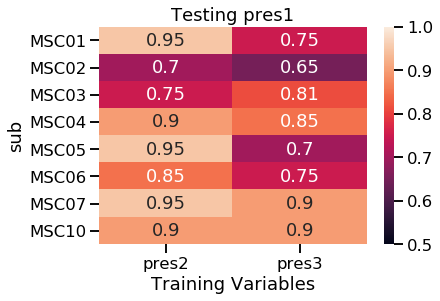

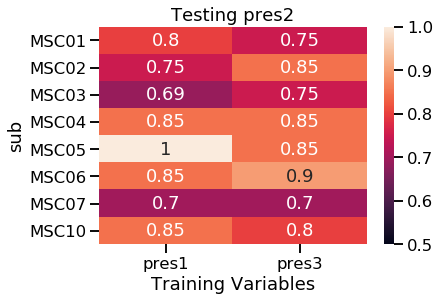

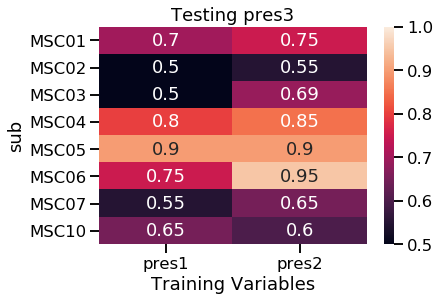

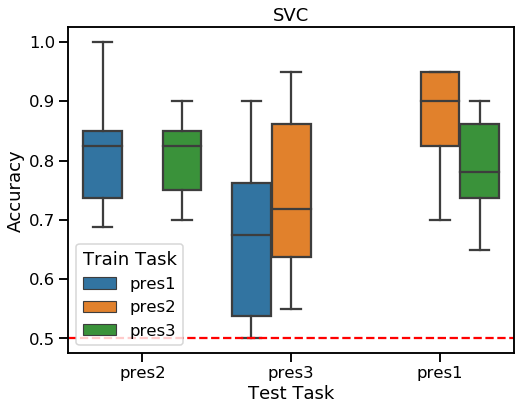

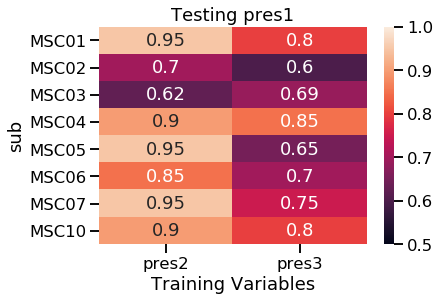

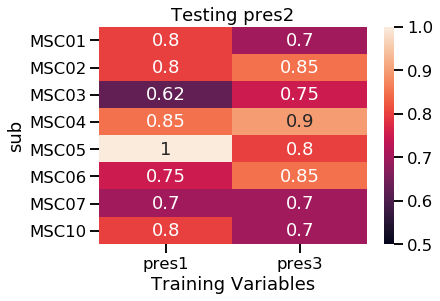

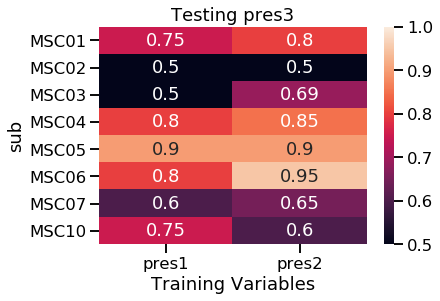

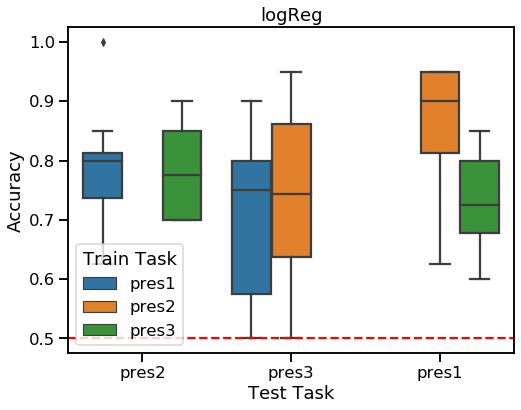

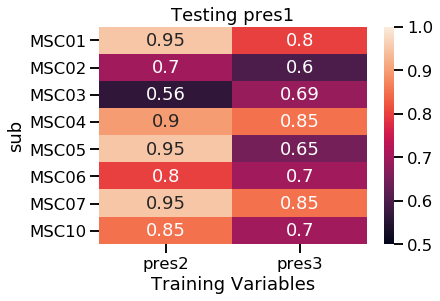

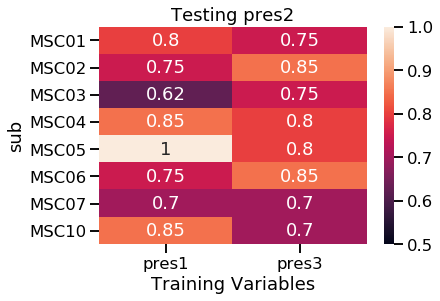

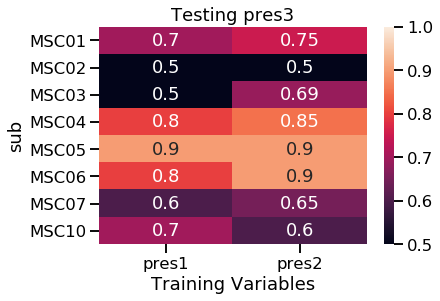

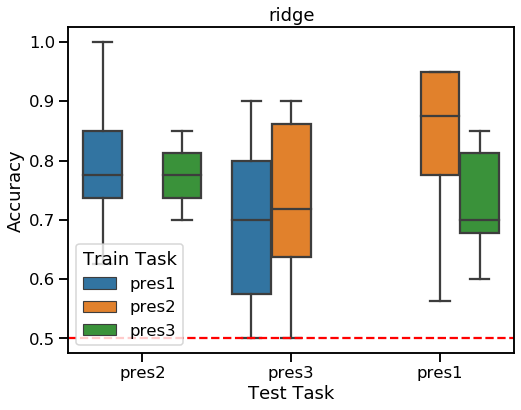

In [13]:
classifierList=['SVC', 'logReg','ridge']
for classifier in classifierList:
    print('Now running '+classifier+' with analysis type SS')
    classifySS(classifier, 'SS')


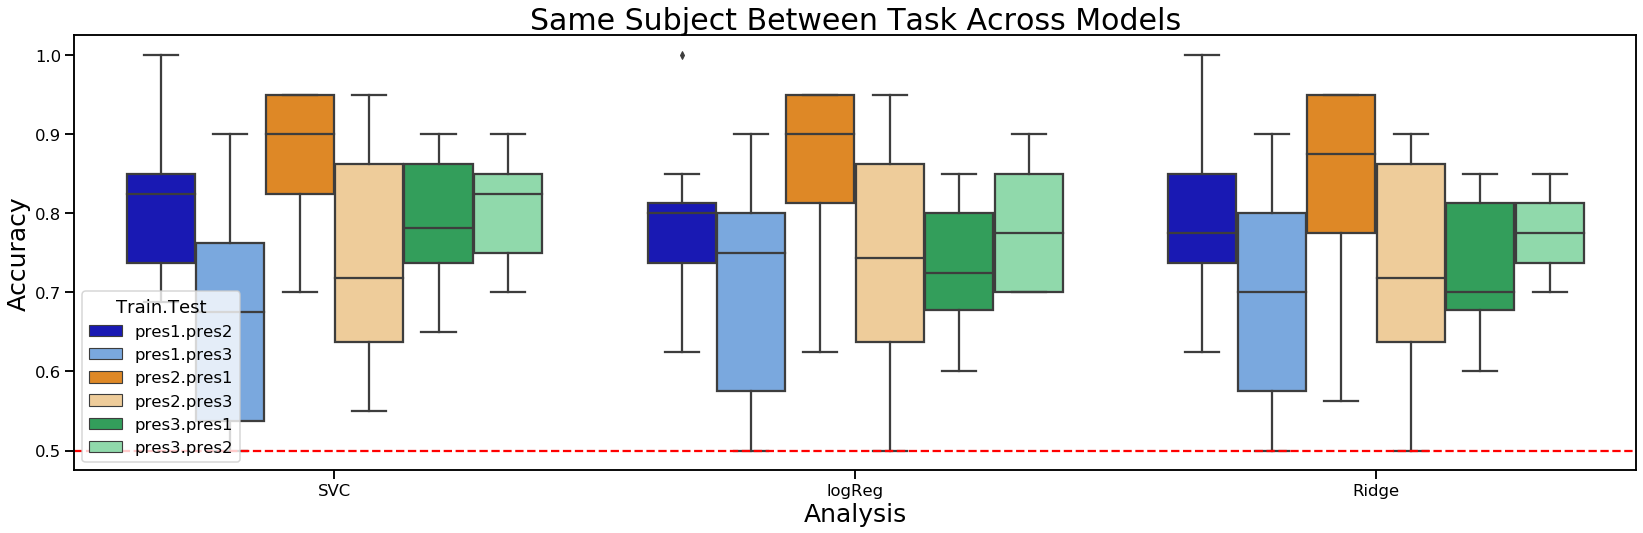

In [14]:
import results
results.ss_boxplot()